In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn
from sklearn import preprocessing
import time
%matplotlib inline

In [2]:
train = pd.read_csv('input/otto_train.csv')
print(train.shape)

(61878, 95)


In [3]:
def encode_features(dat):
    df = pd.DataFrame(index=dat.index.values)
    for c in dat.columns.values:
        unq = np.unique(dat[c])
        arr = np.zeros(len(df))
        for ii, u in enumerate(unq):
            flg = (dat[c] == u).values
            arr[flg] = ii
        df[c] = arr.astype(int)
    return df

In [4]:
x = encode_features(train.drop(['id', 'target'], axis=1))
y = np.array([int(v.split('_')[1])-1 for v in train.target])
print(x.shape, y.shape)

(61878, 93) (61878,)


In [5]:
num_cls = len(np.unique(y))
print(num_cls)

9


In [6]:
prm_base = {
    'booster': 'gbtree',
    'objective': 'multi:softprob',
    'num_class': num_cls,
    'max_depth': 5,
    'learning_rate': 0.1,
    'colsample_bytree': 0.9,
    'subsample': 0.9,
    'silent': 1
}
num_round = 100

In [7]:
np.random.seed(20170611)
flg_train = np.random.choice([False, True], len(y), p=[0.3, 0.7])
flg_valid = np.logical_not(flg_train)

In [8]:
dt_xgb = xgb.DMatrix(x[flg_train], y[flg_train])
dv_xgb = xgb.DMatrix(x[flg_valid], y[flg_valid])

In [9]:
def test_xgb(prm):
    time_s = time.time()
    obj_xgb = xgb.train(
        prm, dt_xgb, num_round
    )
    time_t = time.time()
    return time_t - time_s

In [10]:
prm = prm_base
test_xgb(prm)

24.81910991668701

In [11]:
prm = prm_base
prm.update({'updater': 'grow_gpu'})
ge = test_xgb(prm)

In [12]:
prm = prm_base
prm.update({'updater': 'grow_gpu_hist'})
prm.update({'max_bin': 8})
gh = test_xgb(prm)

In [13]:
val = []
cpu = range(1, 17)
for c in cpu:
    prm = prm_base
    prm.update({'updater': 'grow_colmaker'})
    prm['nthread'] = c
    val.append(test_xgb(prm))
ce = val

In [14]:
val = []
cpu = range(1, 17)
for c in cpu:
    prm = prm_base
    prm.update({'updater': 'grow_fast_histmaker'})
    prm.update({'max_bin': 8})
    prm.update({'nthread': c})
    val.append(test_xgb(prm))
ch = val

In [15]:
df = pd.DataFrame({'CPU': ce})
df['CPU_hist'] = ch
df['GPU']      = ge
df['GPU_hist'] = gh

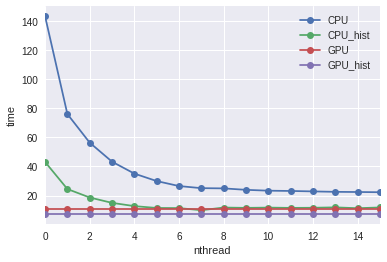

In [16]:
df.plot(style='o-')
plt.xlabel('nthread')
plt.ylabel('time')
plt.show()

In [17]:
df

,CPU,CPU_hist,GPU,GPU_hist
0,143.213904,43.093807,10.793109,7.385136
1,75.984772,24.485343,10.793109,7.385136
2,56.342093,18.662806,10.793109,7.385136
3,43.276191,14.980951,10.793109,7.385136
4,35.087812,12.747035,10.793109,7.385136
5,29.960601,11.476474,10.793109,7.385136
6,26.535089,11.396709,10.793109,7.385136
7,25.082611,9.916659,10.793109,7.385136
8,24.930102,11.761317,10.793109,7.385136
9,23.934886,11.543043,10.793109,7.385136
